In [954]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RF
import time
from sklearn.decomposition import PCA
# import an optimize function
from scipy.optimize import minimize

### Toy Data

In [955]:
# Don't change the ranomd seed or n
np.random.seed(0)
n = 250
smart_factor = np.random.normal(0, 15, n)
smart_factor_norm = smart_factor / np.max(smart_factor)
iq = 100 + smart_factor
iq = iq.astype(int)
education = np.round(14 + np.random.randint(-4, 2, n) + smart_factor_norm * 5).astype(int)
female = np.random.randint(0, 2, n).astype(bool)
age = 30 + np.random.randint(-10, 20, n)
income_level = np.random.choice(['low', 'medium', 'high'], n, p=[0.4, 0.4, 0.2])
criminal_val = -.15 *iq + -2.5*education + -5*female + -15*(income_level == 'high') + -10*(income_level == 'medium') + -10 * (age > 28) + np.random.randint(-20, 20, n)

# take the bottom 10% of the criminal values and label them as criminals
criminals = criminal_val > np.percentile(criminal_val, 90)

# construct a pandas dataframe with the data
df = pd.DataFrame({'iq': iq, 'education': education, 'female': female, 'age': age, 'income_level': income_level, 'criminals': criminals})
df.loc[3, 'criminals'] = True
df.loc[246, 'criminals'] = True
crime_data = df.copy(deep=True)

### Helper Functions

In [956]:
# Find a function that returns the number of rows in a given array
def num_rows(array):
    """ Returns the number of rows in a given array """
    if array is None:
        return 0
    elif len(array.shape) == 1:
        return 1
    else:
        return array.shape[0]

# Define a function that gives the class counts of data
def class_counts(data):
    if len(data.shape) == 1:
        return {data[-1]: 1}
    labels = data[:, -1]
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

### Building Classes

In [957]:
class Question:
    """Questions to use in construction and display of Decision Trees.
    Attributes:
        column (int): which column of the data this question asks
        value (int/float): value the question asks about
        numeric (bool): whether the question is numeric or not
    Methods:
        match: returns boolean of if a given sample answered T/F"""

    def __init__(self, column, value, numeric):
        # Store attributes
        self.column = column
        self.value = value
        self.is_numeric = numeric
        
    def split(self, data):
        """Splits the data into two sets based on the question
        Parameters:
            data ((n,m), ndarray): Data to split
        Returns:
            (ndarray, ndarray): Two arrays split by the question"""
        # Split the data if it is numeric
        if self.is_numeric:
            bools = data[:, self.column] >= self.value
            return data[bools], data[~bools]
        # Handle categorical data
        else:
            bools = data[:, self.column] == self.value
            return data[bools], data[~bools]
        
    def match(self, sample):
        """Returns T/F depending on how the sample answers the question
        Parameters:
            sample ((n,), ndarray): New sample to classify
        Returns:
            (bool): How the sample compares to the question"""
        # Split the data if it is numeric
        if self.is_numeric:
            bools = sample[:, self.column] >= self.value
        # Handle categorical data
        else:
            bools = sample[:, self.column] == self.value
        return bools
            
class Leaf:
    """Tree leaf node
    Attribute:
        prediction (dict): Dictionary of labels at the leaf"""
    def __init__(self, data):
        # Store attributes
        self.prediction = class_counts(data)
        self.train_size = num_rows(data)
    
    # Define a method to get the train size
    def get_train_size(self):
        return self.train_size

    # Define a method to update the test size
    def update_test_size(self, data):
        self.test_size = num_rows(data)

    # Define a method to get the test size
    def get_test_size(self):
        return self.test_size

class Decision_Node:
    """Tree node with a question
    Attributes:
        question (Question): Question associated with node
        left (Decision_Node or Leaf): child branch
        right (Decision_Node or Leaf): child branch"""
    def __init__(self, question, left_branch, right_branch):
        # Store attributes
        self.question = question
        self.left = left_branch
        self.right = right_branch


### ML Functions

In [958]:
# Define a function that calculates the Gini impurity of a given array
def info_gain(data, left, right, tree_type):
    """Return the info gain of a partition of data.
    Parameters:
        data (ndarray): the unsplit data
        left (ndarray): left split of data
        right (ndarray): right split of data
    Returns:
        (float): info gain of the data"""
    if tree_type != 'classification':
        raise NotImplementedError('Info gain only implemented for classification trees')

    def gini(data):
        """Return the Gini impurity of given array of data.
        Parameters:
            data (ndarray): data to examine
        Returns:
            (float): Gini impurity of the data"""
        counts = class_counts(data)
        N = num_rows(data)
        impurity = 1
        for lbl in counts:
            prob_of_lbl = counts[lbl] / N
            impurity -= prob_of_lbl**2
        return impurity
        
    p = num_rows(right)/(num_rows(left)+num_rows(right))
    return gini(data) - p*gini(right)-(1-p)*gini(left)

# Define a function that finds the best split for a given data set
def find_best_split(data, tree_type, size_rand_subset, min_samples_leaf, is_numeric):
    # Get feature_choice, define refinement, and initialize the best gain and current_bool
    feature_choice = np.random.choice(data.shape[1]-1, size_rand_subset, replace=False)
    refinement = 100/np.min([1+np.abs(data.shape[0] -2*min_samples_leaf -2)// min_samples_leaf,40])
    current_q = None
    current_gain = 0

    # Initialize the best gain and question and loop through the first n-1 columns
    for i in feature_choice:
        screen = data[:,i]

        # if it is numeric, get the unique split values based on the refinement
        if is_numeric[i]:
            split_vals = np.unique(np.percentile(screen, np.arange(refinement, 100, refinement)))
            # Loop through the split values and partition the data
            for value in split_vals:
                bool_splits = (screen >= value) 

                # If the partition is too small, skip it
                if (np.sum(bool_splits) < min_samples_leaf) or (np.sum(~bool_splits) < min_samples_leaf):
                    continue

                # Calculate the info gain and update the best gain and question if necessary
                gain = info_gain(data, data[bool_splits], data[~bool_splits], tree_type)
                if gain > current_gain:
                    current_gain, current_q = gain, (i, value, True)
        
        # If it is not numeric, get the unique values and the size
        else:
            categories = np.unique(screen)
            cat_size = len(categories)

            # If there are only two categories, there is only one possible split
            if cat_size == 2:
                cat_splits = [[0]]

            # If there are more than two categories, there are many different possible splits. Split individually and then choose random splits
            else:
                cat_splits = [i for i in range(cat_size)]
                random_splits = [np.random.choice(categories, size, replace=False) for size in np.arange(2, cat_size-1, 1)]
                if len(random_splits) > 0:
                    cat_splits.append(random_splits)
                
            # Get the unique splits
            for split in cat_splits:
                bool_splits = np.isin(screen, split)

                # If the partition is too small, skip it
                if (np.sum(bool_splits) < min_samples_leaf) or (np.sum(~bool_splits) < min_samples_leaf):
                    continue
            
                # Calculate the info gain and update the best gain and question if necessary
                gain = info_gain(data, data[bool_splits], data[~bool_splits], tree_type)
                if gain > current_gain:
                    current_gain, current_q = gain, (i, split, False)
    
    # If there is no best question, return None, otherwise return the best question
    if current_q is None:
        return 0, None
    else:
        return current_gain, Question(current_q[0], current_q[1], current_q[2])

# Define a function that predicts a decision tree
def predict_tree(sample, my_tree, predictions, joint_pdf):
    """Predict the label for a sample given a pre-made decision tree
    Parameters:
        sample (ndarray): a single sample
        my_tree (Decision_Node or Leaf): a decision tree
    Returns:
        Label to be assigned to new sample"""

    # Base case if my_tree is a leaf
    if isinstance(my_tree, Leaf):
        if joint_pdf:
            # Gets the total weight of the leaf
            predictions[:] = my_tree.get_train_size()
        else:
            # Gets the most common label of the leaf
            predictions[:] = max(my_tree.prediction, key=my_tree.prediction.get)
        return predictions

    # Otherwise break it down into left and right branches
    bools = my_tree.question.match(sample)
    left, right = sample[bools], sample[~bools]

    # Recursively call predict_tree on the left and right branches to fill in the predictions array
    predictions[bools] = predict_tree(left, my_tree.left, predictions[bools], joint_pdf)
    predictions[~bools] = predict_tree(right, my_tree.right, predictions[~bools], joint_pdf)
    return predictions



### Main Classes (DecisionTree, AdaptiveForest)

In [959]:
class DecisionTree:
    """
    A decision tree class that can be used for classification.
    Attributes:
        data (numpy array): data to use for the tree
        features (list): list of feature names
        min_samples_leaf (int): minimum number of samples in a leaf
        max_depth (int): maximum depth of the tree
        is_numeric (numpy array - boolean): boolean array indicating whether each feature is numeric or not
        size_random_subset (int): number of features to use for each split
        y (numpy array): target variable
        X (numpy array): data without the target variable
    """

    def __init__(self, data, tree_type, features, min_samples_leaf, max_depth, is_numeric, size_random_subset):
        """
        Initialize the decision tree
        Inputs:
            data (numpy array): data to use for the tree (target in last column)
            tree_type (str): type of tree (classification or regression)
            features (list): list of feature names
            min_samples_leaf (int): minimum number of samples in a leaf
            max_depth (int): maximum depth of the tree
            is_numeric (numpy array - boolean): boolean array indicating whether each feature is numeric or not
            size_random_subset (int): number of features to use for each split
        """
        # Initialize the different attributes of the tree
        self.data = data
        self.tree_type = tree_type
        self.features = features
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.is_numeric = is_numeric
        self.size_random_subset = size_random_subset

    # Define a method to build a tree
    def build_tree(self, data, current_depth=0):
        """Build a classification tree using the classes Decision_Node and Leaf
        Parameters:
            data (ndarray)
            min_samples_leaf (int): minimum allowed number of samples per leaf
            max_depth (int): maximum allowed depth
            current_depth (int): depth counter
            random_subset (bool): whether or not to train on a random subset of features
        Returns:
            Decision_Node (or Leaf)"""
        # If the number of rows is less than the minimum samples per leaf, return a leaf
        if data.shape[0] < 2*self.min_samples_leaf:
            return Leaf(data)
        
        # Find the best question to ask and return a leaf if there is no gain or past max depth
        gain, question = find_best_split(data, self.tree_type, self.size_random_subset, self.min_samples_leaf, self.is_numeric)
        if gain == 0 or current_depth >= self.max_depth:
            return Leaf(data)
        
        # Partition the data and build the left and right branches
        left, right = question.split(data)
        left_branch = self.build_tree(left, current_depth+1)
        right_branch = self.build_tree(right, current_depth+1)

        # Return a Decision_Node with the best question and branches
        return Decision_Node(question, left_branch, right_branch)
    
    # Define a method to fit the tree
    def fit(self):
        self.tree = self.build_tree(self.data)

    # Define a method to predict the labels for a sample
    def predict(self, sample, joint_pdf = False):
        """Predict the label for a sample
        Parameters:
            sample (ndarray): a single sample
        Returns:
            Label to be assigned to new sample"""
        # Make sure the sample is a 2D array
        if len(sample.shape) == 1:
            sample = sample.reshape(1, -1)

        # Initialize the predictions array and predict the label
        predictions = np.zeros(len(sample))
        return predict_tree(sample, self.tree, predictions, joint_pdf)
        
class AdaptiveForest:
    """ A random forest class that can be used for classification or regression.
    Attributes:
        data (numpy array): data to use for the forest
        features (list): list of feature names
        min_samples_leaf (int): minimum number of samples in a leaf
        max_depth (int): maximum depth of the tree
        is_numeric (numpy array - boolean): boolean array indicating whether each feature is numeric or not
        category_codes (dict): dictionary of the category codes for each non numeric feature
        size_random_subset (int): number of features to use for each split
        n_trees (int): number of trees in the forest
        weights (numpy array): weights for each tree
        trees (list): list of trees in the forest
        bootstrap_size (int): size of the boot strap sample
        data_size (int): size of the data
        class_n (int): number of classes
        forest_type (str): type of forest (classification or regression)

    Methods:
        access_tree: access the decision tree class
        print_codes: print the category codes
        fit: fit the random forest
        fit_with_oob: fit the random forest with out of bag data
        predict: predict the label for a sample with the ensemble
    """
    
    def __init__(self,dataframe, labels = None, target_index = None, n_trees = 10, min_samples_leaf=5, max_depth=4, features = None, size_rand_subset = None, bootstrap_size = None):
        """
        Initialize the random forest
        Inputs:
            dataframe (pandas dataframe or numpy array): data to use for the forest (target in last column)
            labels (numpy array): labels to use for the forest
            target_index (int): index of the target variable
            n_trees (int): number of trees in the forest
            min_samples_leaf (int): minimum number of samples in a leaf
            max_depth (int): maximum depth of the tree
            features (list): list of feature names
            size_rand_subset (int): number of features to use for each split
            bootstrap_size (int): size of the boot strap sample
        """
        #### Data preprocessing ####
        # Check the data type and raise an error if it is not a dataframe or numpy array
        if isinstance(dataframe, np.ndarray):
            df = pd.DataFrame(dataframe)

            # Check if the data is numeric and convert it if it is not
            def infer_dtype(col):
                try:
                    return pd.to_numeric(col, errors='raise')
                except:
                    return col
            df = df.apply(lambda col: infer_dtype(col))
            if features is not None:
                df.columns = features
        
        # If the data is a dataframe, then make a copy of it, raise an error otherwise
        elif isinstance(dataframe, pd.DataFrame):
            df = dataframe.copy(deep=True)
        else:
            raise ValueError('Data must be a pandas dataframe or numpy array')

        # If labels are given, then make them a series and concatenate them to the dataframe if conditions met
        if labels is not None:
            labels = pd.Series(labels)
            if target_index is not None:
                raise ValueError('Cannot have both labels and target index')
            
            # check if labels and dataframe have the same number of rows
            if len(labels) != len(df):
                raise ValueError('Labels and dataframe must be same size')
            
            # concatenate the labels to the dataframe
            labels.name = 'target'
            df = pd.concat([df, labels], axis=1)

        # If labels are not given, then check if target index is given and move the target variable to the last column
        else:
            if target_index is None:
                print('Warning: No target index given. Using last index as target variable.')
            else:
                cols = list(df.columns)
                cols.append(cols.pop(target_index))
                df = df[cols]

        #### Initialize tree attributes ####
        # Save the features except for the target variable and check the target column data type
        self.features = np.array(df.columns)
        target_dtype = df[self.features[-1]].dtype

        # check if the target variable is numeric
        if isinstance(target_dtype, (int, float, complex)):
            self.forest_type = 'regression'
        else:
            self.forest_type = 'classification'

        # Check which features are numeric and save the boolean mask
        numeric_cols = df.select_dtypes(include=['number']).columns
        self.is_numeric = df.columns.isin(numeric_cols)
        self.category_codes = {}
     
        # Loop through non numeric columns and convert them to numeric while saving the category codes
        for col in self.features[~self.is_numeric]:
            self.category_codes[col] = dict(enumerate(df[col].astype('category').cat.categories))
            df[col] = df[col].astype('category').cat.codes
    
        # Save the size of the random subset for attribute bagging
        if size_rand_subset is None:
            self.size_rand_subset = int(np.ceil(np.sqrt(len(self.features) - 1)))
        else:
            self.size_rand_subset = size_rand_subset

        # Initialize data and min_samples_leaf
        self.data = df.values.astype(float)
        if min_samples_leaf is None:
            self.min_samples_leaf = 1
        else:
            self.min_samples_leaf = min_samples_leaf

        # Initialize the max depth
        if max_depth is None:
            self.max_depth = np.inf
        else:
            self.max_depth = max_depth

        # Save the data size and number of classes
        self.data_size = self.data.shape[0]
        self.class_n = len(np.unique(self.data[:,-1]))

        #### Other forest attributes ####
        # Save the boot strap size if given
        if bootstrap_size is None:
            self.bootstrap_size = df.shape[0]
        else:
            self.bootstrap_size = bootstrap_size

        # Save the number of trees, the weights, and initialize the trees
        self.n_trees = n_trees
        self.weights = np.ones(self.n_trees) / self.n_trees
        self.trees = []

    def access_tree(self):
        """ Access the decision tree class """
        return DecisionTree(self.data, self.forest_type, self.features, self.min_samples_leaf, self.max_depth, self.is_numeric, self.size_rand_subset)
        
    def print_codes(self):
        """ Print the category codes """
        max_key_length = max(len(str(key)) for key in self.category_codes)
        for key in self.category_codes:
            print("{:<{width}} {}".format(str(key), "---  "+str(self.category_codes[key]), width=max_key_length + 1))

    def fit(self, bootstrap_size = None):
        """ Fit the random forest """
        # If a new bootstrap size is given, update the bootstrap size
        if bootstrap_size is not None:
            self.bootstrap_size = bootstrap_size

        # Loop through the number of trees and fit each tree to bootstrapped data
        for _ in range(self.n_trees):
            # boot strap our data, build a tree, and fit the tree
            indices = np.random.choice(self.data_size, self.bootstrap_size, replace=True)
            sample = self.data[indices]
            tree = DecisionTree(sample, self.forest_type, self.features, self.min_samples_leaf, self.max_depth, self.is_numeric, self.size_rand_subset)
            tree.fit()

            # append the tree to the forest
            self.trees.append(tree)

    def fit_with_oob(self):
        raise NotImplementedError('Out of bag not yet implemented')
        # get the out of bag data
        # oob_indices = np.setdiff1d(np.arange(n_samples), indices, assume_unique=True)
        # oob_data = self.data[oob_indices]
        # self.oob_data.append(oob_data)
    
    def predict(self, sample, weighted = False, labeled = False):
        """ Predict the label for a sample with the ensemble"""
        # Initialize the ensemble predictions and loop through the trees
        ensemble = np.zeros((len(sample),self.n_trees))
        for i in range(self.n_trees):
            ensemble[:,i] = self.trees[i].predict(sample)

        # Determine the weights to use
        weights = None
        if weighted:
            weights = self.weights

        # Get the predicted labels
        ensemble = ensemble.astype(int)
        predicted = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, minlength=np.max(ensemble)+1, weights=weights)), axis=1, arr=ensemble)

        # If the labels are not given, return the predicted labels
        if not labeled:
            return predicted
        
        # Otherwise return a vector with the category codes
        else:
            return np.vectorize(self.category_codes[self.features[-1]].get)(predicted.astype(int))
        
    def get_leaf_probabilities(self, grid):
        """ Get the probability of each leaf for a sample """
        # Initialize the leaf probabilities
        leaf_probs = np.zeros((len(grid),self.n_trees))
        for i in range(self.n_trees):
            leaf_probs[:,i] = self.trees[i].predict(grid, joint_pdf=True)
        return leaf_probs / self.data_size
    
    def update_weights(self, sample, lb = 0, ub = 1, lam = 0):
        """ Update the weights of the trees
        Parameters:
            sample (ndarray): a sample of the data not including the label
            generalized (float): generalized entropy parameter
        """
        # Get the leaf probabilities and update the weights
        leaf_probs = self.get_leaf_probabilities(sample)

        # Objective Function
        def objective(w, leaf_probs):
            return -np.sum(np.log(leaf_probs @ w)) + lam * np.linalg.norm(w, ord=2)**2 / self.n_trees

        # Constraint: sum of weights equals 1
        def constraint(w):
            return np.sum(w) - 1

        # Initial guess for weights (should sum to 1)
        w0 = np.full(self.n_trees, 1/self.n_trees)

        # Define constraints (both equality and non-negativity)
        cons = ({'type': 'eq', 'fun': constraint})
        bounds = [(lb, ub)] * self.n_trees  # Ensures all weights are non-negative

        # Perform optimization
        # try slsqp minimization and other types
        opt_result = minimize(objective, w0, args=(leaf_probs,), constraints=cons, bounds=bounds)
        self.weights = opt_result.x

        

In [960]:
# upload the small minst data set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # load the data
# digits = load_digits()
# X = digits.data
# y = digits.target

# # split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# # fit random forest classifier with 100 trees
# rf = RandomForestClassifier(n_estimators=100)
# rf.fit(X_train, y_train)

# # get predictions
# y_pred = rf.predict(X_test)

# # get accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy: {:.3f}'.format(accuracy))

# # get confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# #display(cm)

# # import time
# # # Do the same for adaptive forest
# # start = time.time()
# # af = AdaptiveForest(X_train, y_train, n_trees=100)
# # end = time.time()
# # print('Time to initialize: {:.3f}'.format(end-start))
# # start = time.time()
# # af.fit()
# # end = time.time()



# start = time.time()
# y_pred = af.predict(X_test, weighted=True)
# end = time.time()
# print('Time to predict: {:.3f}'.format(end-start))

# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy: {:.3f}'.format(accuracy))
# cm = confusion_matrix(y_test, y_pred)
# #display(cm)

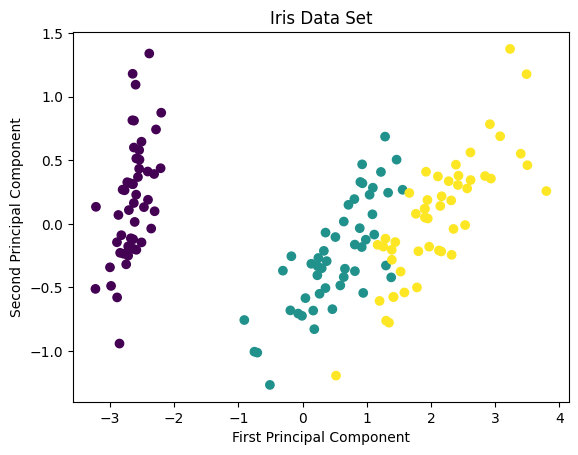

In [961]:
# load the iris data set
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# do PCA on the iris data set
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# graph the iris data set with the first two principal components
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Iris Data Set')
plt.show()

In [962]:
# run the adaptive forest on the pca iris data set
af = AdaptiveForest(X_pca, y, n_trees=1000, size_rand_subset=1)
af.fit()

In [963]:
# make a grid of the first two principal components
x_min, x_max = X_pca[:, 0].min(), X_pca[:, 0].max()
y_min, y_max = X_pca[:, 1].min(), X_pca[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# get the leaf probabilities for the grid
leaf_probs = af.get_leaf_probabilities(grid)

In [967]:
size = 300 
guassian = np.random.normal(0, 1.3, 2 * size).reshape(size,2) + np.array([2,.25])
af.update_weights(guassian)

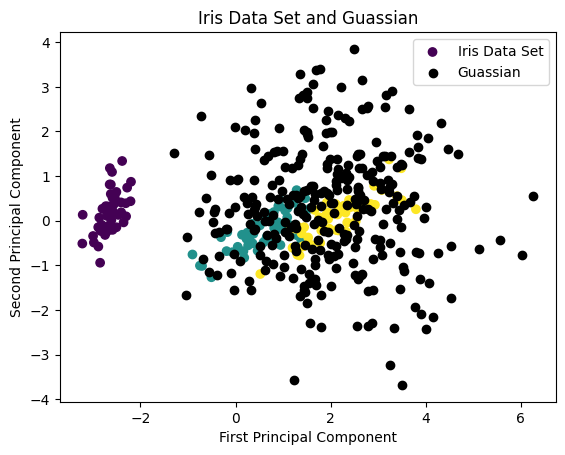

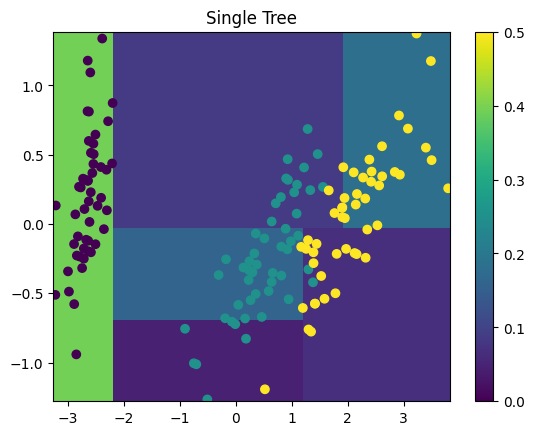

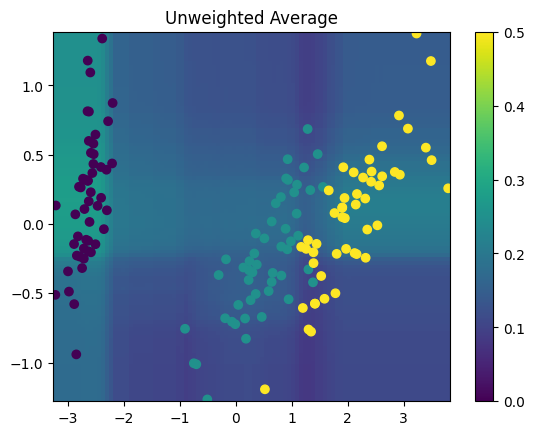

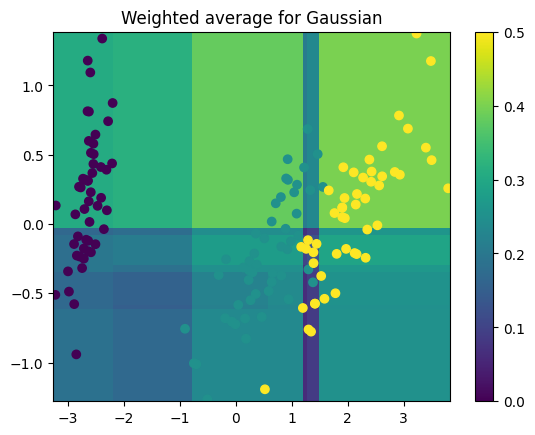

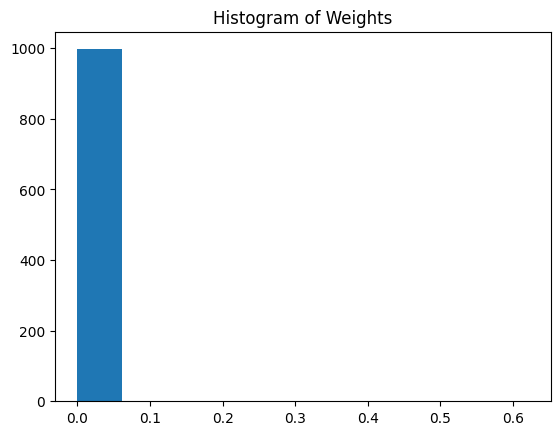

[0.62106 0.30632 0.0724  0.00023 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     

In [972]:
# plot the guassian on top of the iris data set
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.scatter(guassian[:,0], guassian[:,1], c='black')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Iris Data Set and Guassian')
plt.legend(['Iris Data Set', 'Guassian'])
plt.show()

single_plot = leaf_probs[:,1].reshape(xx.shape)
plt.pcolormesh(xx, yy, single_plot, vmin=0, vmax=.5, cmap='viridis')
plt.colorbar()
# overlay the scatter plot of the data
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title('Single Tree')
plt.show()

mean_plot = np.mean(leaf_probs, axis=1).reshape(xx.shape)
plt.pcolormesh(xx, yy, mean_plot, vmin=0, vmax=.5, cmap='viridis')
plt.colorbar()
# overlay the scatter plot of the data
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title('Unweighted Average')
plt.show()

#plot_values = np.mean(leaf_probs, axis=1).reshape(xx.shape)
weights = af.weights
plot_values = (leaf_probs @ weights).reshape(xx.shape)
plt.pcolormesh(xx, yy, plot_values, vmin=0, vmax=.5, cmap='viridis')
plt.colorbar()
# overlay the scatter plot of the data
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title('Weighted average for Gaussian')
plt.show()

# sort the weights and get the histogram
sorted_weights = np.sort(weights)[::-1]
plt.hist(sorted_weights)
plt.title('Histogram of Weights')
plt.show()

# make it not in scientific notation
np.set_printoptions(suppress=True)
print(np.round(sorted_weights,5))



In [ ]:
def map_tree(tree):
    curr_depth, curr_lat, structure, axis = 0, 0, np.zeros((tree.max_depth, 2**(tree.max_depth-2))), -10 * np.ones((tree.max_depth, 2**(tree.max_depth-2)))
    def recurse(tree, curr_depth, curr_lat, structure, axis):
        structure[curr_depth, curr_lat] = tree.question.value
        axis[curr_depth, curr_lat] = tree.question.column
        if isinstance(tree.left, Decision_Node):
            recurse(tree.left, curr_depth+1, curr_lat*2, structure, axis)
        if isinstance(tree.right, Decision_Node):
            recurse(tree.right, curr_depth+1, curr_lat*2+1, structure, axis)
    recurse(tree.tree, curr_depth, curr_lat, structure, axis)
    return np.round(structure,3), axis

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, plot_values, cmap='viridis')
ax.plot(X_pca[:,0], X_pca[:,1], 'k.', markersize=2)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('p(x, 0) + p(x, 1)')
# change the view angle
ax.view_init(30, -60)
plt.show()

In [ ]:
employee = pd.read_csv('Employee.csv')

In [ ]:
train_size = .2
bang_percent = .1
pune_percent = .1

# calculate the percent of employees in each location
nd_percent = 1 - bang_percent - pune_percent
Bangalore = employee.query('City == "Bangalore"')
Pune = employee.query('City == "Pune"')
New_Delhi = employee.query('City == "New Delhi"')
total_count = len(employee)

# Calculate the number of employees to use in the sample
bang_size = int(total_count*train_size*bang_percent)
pune_size = int(total_count*train_size*pune_percent)
nd_size = int(total_count*train_size*nd_percent)

# randomly choose the employees to use in the sample based on the sizes
np.random.seed(0)
bang_sample = Bangalore.sample(bang_size)
pune_sample = Pune.sample(pune_size)
nd_sample = New_Delhi.sample(nd_size)

# concatenate the samples
train = pd.concat([bang_sample, pune_sample, nd_sample])

# Get the out of bag data
test = employee[~employee.index.isin(train.index)]

# get the labels
y_train = train['LeaveOrNot'].values
y_test = test['LeaveOrNot'].values
X_train = train.drop('LeaveOrNot', axis=1).values
X_test = test.drop('LeaveOrNot', axis=1).values

In [936]:
af = AdaptiveForest(X_train, y_train, n_trees=1000)
af.fit()

In [943]:
preds = af.predict(X_test)
accuracy_score(y_test, preds)

0.7319366102605426

In [938]:
af.update_weights(X_test)

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [944]:
preds = af.predict(X_test, weighted=True)
accuracy_score(y_test, preds)

0.7319366102605426

Mean: 0.001
Median: 0.000
Max: 0.010
Min: 0.000
Std: 0.003


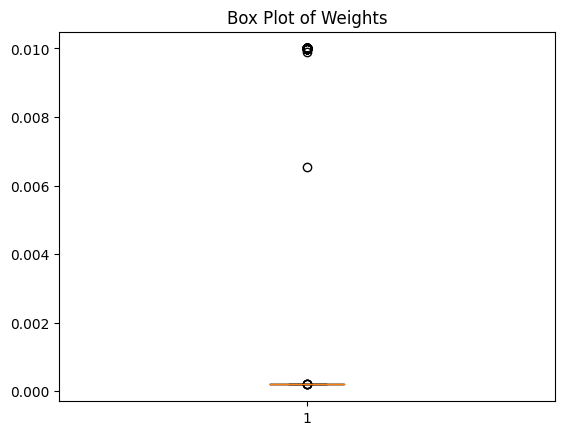

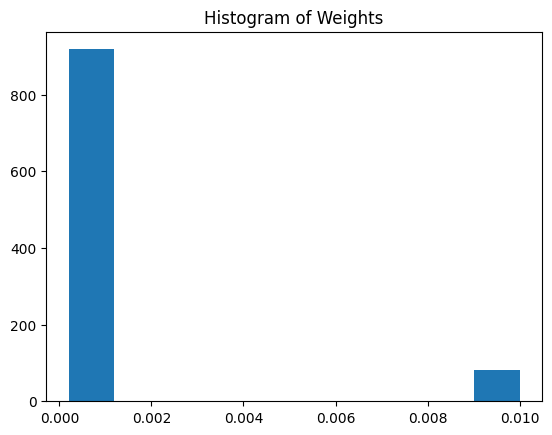

0.009999899705440749


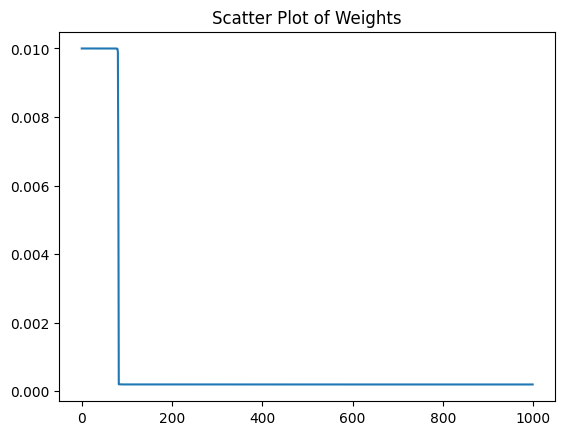

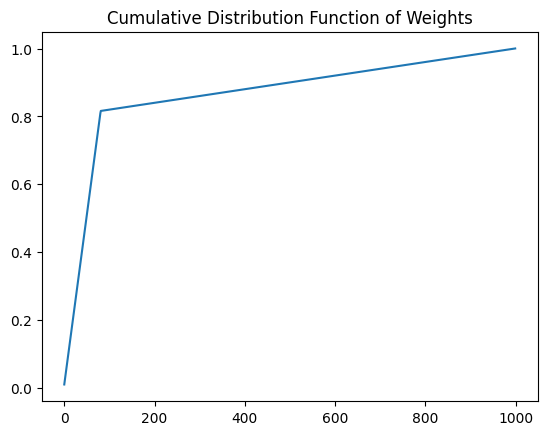

array([0.0099999 , 0.0099999 , 0.00999989, 0.00999989, 0.00999988,
       0.00999988, 0.00999988, 0.00999987, 0.00999987, 0.00999987,
       0.00999987, 0.00999987, 0.00999987, 0.00999986, 0.00999986,
       0.00999986, 0.00999986, 0.00999986, 0.00999986, 0.00999985,
       0.00999985, 0.00999985, 0.00999985, 0.00999985, 0.00999985,
       0.00999985, 0.00999984, 0.00999984, 0.00999984, 0.00999983,
       0.00999983, 0.00999983, 0.00999983, 0.00999983, 0.00999983,
       0.00999983, 0.00999983, 0.00999983, 0.00999983, 0.00999982,
       0.00999982, 0.00999982, 0.00999982, 0.00999982, 0.00999982,
       0.00999981, 0.00999981, 0.00999981, 0.00999981, 0.0099998 ,
       0.0099998 , 0.00999979, 0.00999978, 0.00999977, 0.00999975,
       0.00999969, 0.00999961, 0.00999952, 0.0099995 , 0.00999942,
       0.00999941, 0.00999938, 0.00999936, 0.00999935, 0.0099993 ,
       0.00999929, 0.00999929, 0.00999928, 0.00999925, 0.00999925,
       0.00999925, 0.00999922, 0.00999918, 0.00999904, 0.00999

In [945]:
# sort the weights from descending order
weights = af.weights
sort_weights = np.argsort(weights)[::-1]
sorted = weights[sort_weights]

# print the statistics of the weights
print('Mean: {:.3f}'.format(np.mean(sorted)))
print('Median: {:.3f}'.format(np.median(sorted)))
print('Max: {:.3f}'.format(np.max(sorted)))
print('Min: {:.3f}'.format(np.min(sorted)))
print('Std: {:.3f}'.format(np.std(sorted)))

# show the box plot of the weights
plt.boxplot(sorted)
plt.title('Box Plot of Weights')
plt.show()

# show the histogram of the weights
plt.hist(sorted)
plt.title('Histogram of Weights')
plt.show()

# show the scatter plot of the weights
plt.plot(np.arange(len(sorted)), sorted)
print(sorted[0])
plt.title('Scatter Plot of Weights')
plt.show()

# show the cumulative distribution function of the weights
plt.plot(np.arange(len(sorted)), np.cumsum(sorted))
plt.title('Cumulative Distribution Function of Weights')
plt.show()


display(sorted)

In [952]:
X = employee[employee.columns[:-1]].values
y = employee['LeaveOrNot'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
af2 = AdaptiveForest(X_train, y_train, n_trees=1000)
af2.fit()
preds = af2.predict(X_test)
accuracy_score(y_test, preds)


0.7400644468313641

In [973]:
employee

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0
